# For defining reaction templates used in polymer fragment generation

# Core Imports

In [3]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.amalgamation import portlib

from polymerist.rdutils.smileslib.functgroups import FN_GROUP_TABLE
from polymerist.monomers import specification

# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('poly_rxns')
RXN_FILES_PATH.mkdir(exist_ok=True)

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Defining target functional groups

### Locate base SMARTS to build off of

In [4]:
gb = FN_GROUP_TABLE.groupby('group_name')
smarts_keys = {
    'hydroxyl'      : ('Hydroxyl', 156),
    'carboxyl'      : ('Carboxylic acid', 51),
    'carbamate'     : ('Carbamate.', 46),
    'acyl_chloride' : ('Acyl Halide', 237),
    'isocyanate'    : ('Cyanamide', 54),
    'ester'         : ('Ester Also hits anhydrides', 58)
}

smarts_dict, mol_dict = {}, {}
for fn_group_name, (group_key, idx) in smarts_keys.items():
    smarts = gb.get_group(group_key).loc[idx].SMARTS
    rdmol = Chem.MolFromSmarts(smarts)

    print(fn_group_name, smarts)
    # display(rdmol)

    smarts_dict[fn_group_name] = smarts 
    mol_dict[fn_group_name] = rdmol 

hydroxyl [OX2H]
carboxyl [CX3](=O)[OX2H1]
carbamate [NX3,NX4+][CX3](=[OX1])[OX2,OX1-]
acyl_chloride [CX3](=[OX1])[F,Cl,Br,I]
isocyanate [NX3][CX2]#[NX1]
ester [#6][CX3](=O)[OX2H0][#6]


### Define functional groups (with R-group linkers) as basis for desired reactions

phthalimide


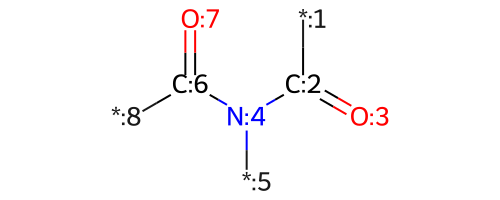

carbamate


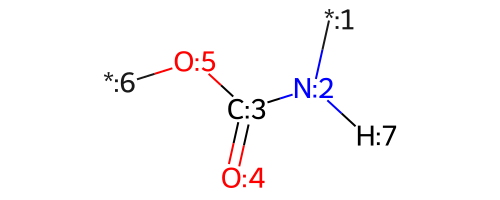

cyclocarbonate


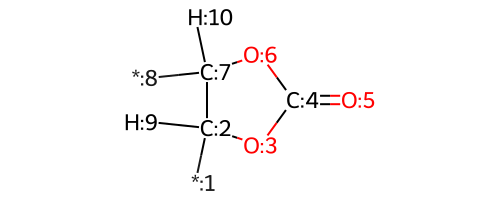

anhydride


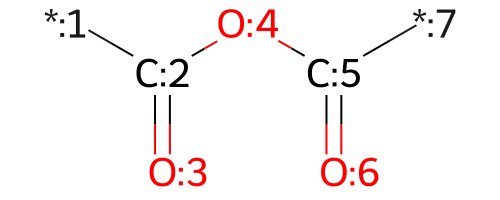

vinyl


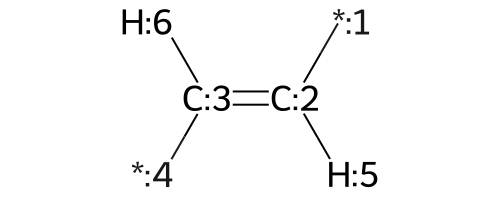

acyl_chloride


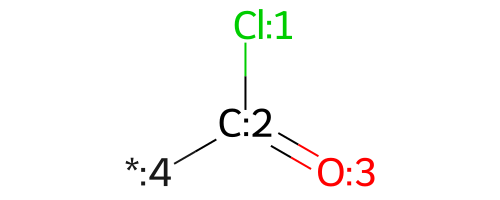

carboxyl


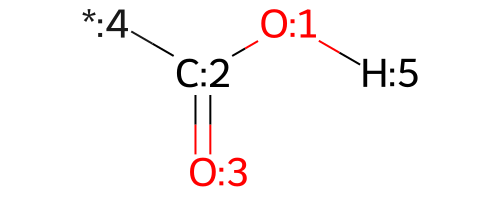

ester


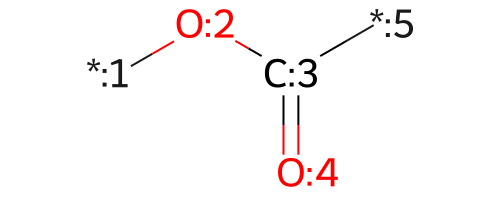

amine


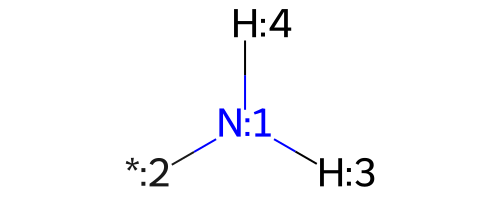

hydroxyl


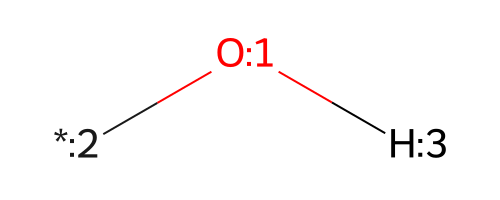

isocyanate


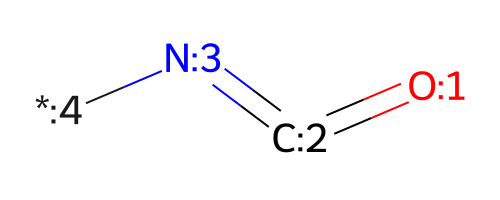

In [5]:
rdkdraw.set_rdkdraw_size(200, 5/2)

fn_group_smarts_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthalimide'   : '*C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    'cyclocarbonate' : '*C1OC(=O)OC1*',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : '*C=C*',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_group_smarts, fn_groups = {}, {}
for group_name, smiles in fn_group_smarts_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=True)
    fn_group_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    for atom in fn_group_mol.GetAtoms():
        if portlib.is_linker(atom):
            atom.SetProp('molFileValue', group_name)
            break # ensure this is only set once
    
    print(group_name)
    display(fn_group_mol)

    fn_group_smarts[group_name] = exp_smiles
    fn_groups[      group_name] = fn_group_mol

### Define complete small-molecule byproducts (as query mols)

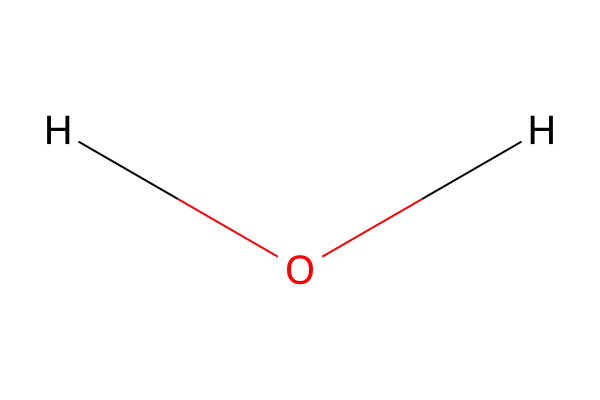

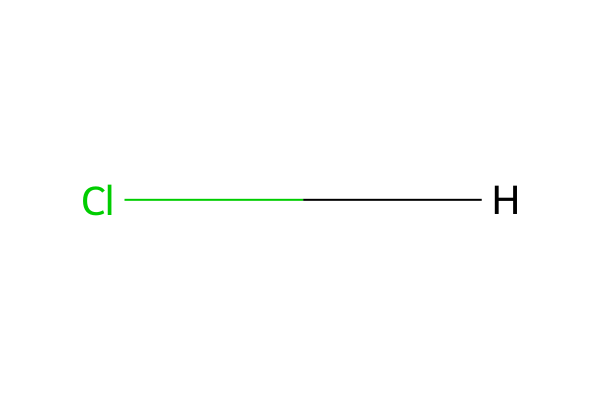

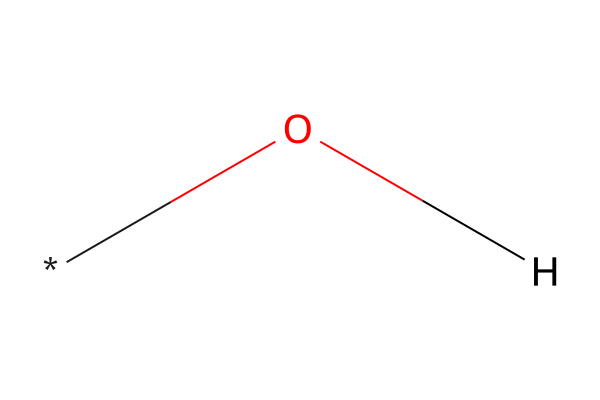

In [9]:
byproduct_smarts_bare = {
    'water' : 'O',
    'hcl'   : '[ClH]',
    'alcohol' : 'O*'
}

byproduct_smarts, byproducts = {}, {}
for group_name, smiles in byproduct_smarts_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=False)
    byproduct = Chem.MolFromSmarts(exp_smiles) # must be SMARTS for successful query

    byproduct_smarts[group_name] = exp_smiles
    byproducts[group_name] = byproduct
    display(byproduct)

## Export functional group and byproduct smiles to files

In [11]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smarts, file, indent=4)

with (RXN_FILES_PATH / 'byprod_smarts.json').open('w') as file:
    json.dump(byproduct_smarts, file, indent=4)

# Defining polymerization reactions

In [15]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler

rdkdraw.set_rdkdraw_size(400, 3/2)
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups


mechanisms : dict[str, ReactionAssembler] = {
    'polyester' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polyamide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 6),
            5 : (6, 3)
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polyimide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['anhydride'],
        ),
        bond_derangement={
            4 : (1, 8),
            6 : (8, 1),
            3 : (1, 8), # doubles up carbonyl transfer - must have target atoms as beginning to maintain canonical derangement form
            9 : (8, 1),
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polycarbonate_phosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['acyl_chloride'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=(
            byproducts['hcl'],
        )
    ),
    'polycarbonate_nonphosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['ester'],
        ),
        bond_derangement= {
            5 : (6, 3),
            1 : (3, 6)
        },
        # bond_derangement= { # technically would give desired end products but is...
        #     4 : (5, 1), # ... inconsistent w/ mechanism of action (relative to phosgene route)...
        #     2 : (1, 5)  # ...AND prohibited by the Port spec (would produce 2 neutronium fragments which are unbondable)
        # },
        byproducts=(
            byproducts['alcohol'],
        )
    ),
    'polyurethane_isocyanate' : ReactionAssembler(
        reactive_groups=(
            fn_groups['isocyanate'],
            fn_groups['hydroxyl'],
        ),
        bond_derangement={
            7 : (5, 3),
            2 : (3, 5)
        }
    ),
    'polyurethane_nonisocyanate' : ReactionAssembler(
        reactive_groups=(
            fn_groups['cyclocarbonate'],
            fn_groups['amine'],
        ),
        bond_derangement= {
            5  : (4, 13),
            11 : (13, 4)
        }
    ),
    'polyvinyl_head_tail' : ReactionAssembler(
        reactive_groups=(
            fn_groups['vinyl'],
            fn_groups['vinyl'],
        ),
        bond_derangement= {
            3  : (2, 8),
            12 : (8, 2)
        }
    ),
}

polyester {1: (3, 5), 4: (5, 3)}


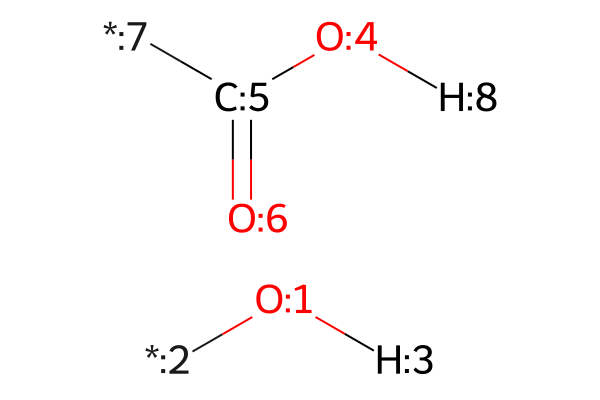

polyamide {1: (3, 6), 5: (6, 3)}


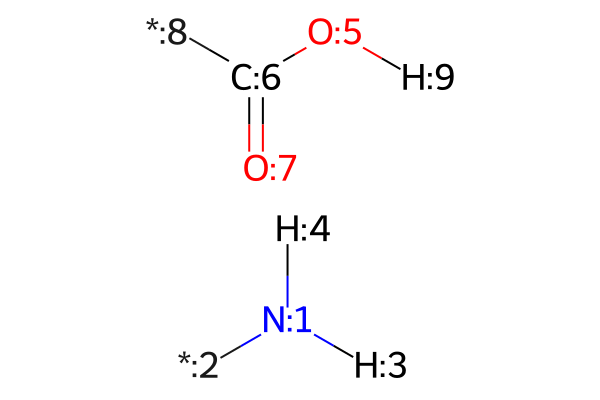

polyimide {4: (1, 8), 6: (8, 1), 3: (1, 8), 9: (8, 1)}


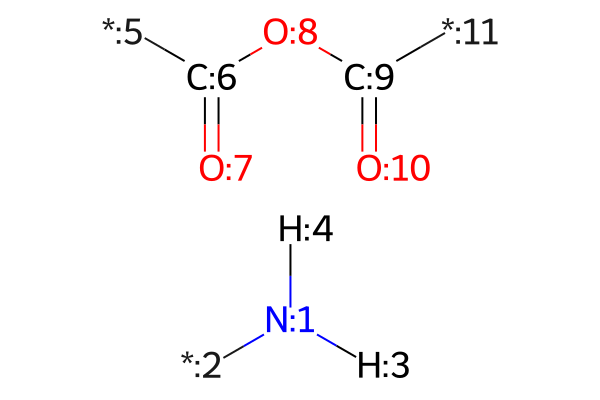

polycarbonate_phosgene {1: (3, 5), 4: (5, 3)}


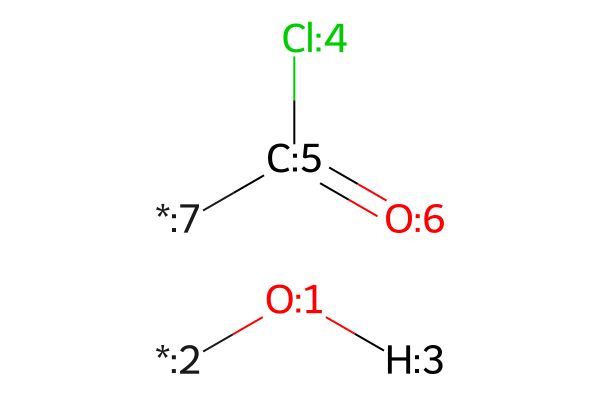

polycarbonate_nonphosgene {5: (6, 3), 1: (3, 6)}


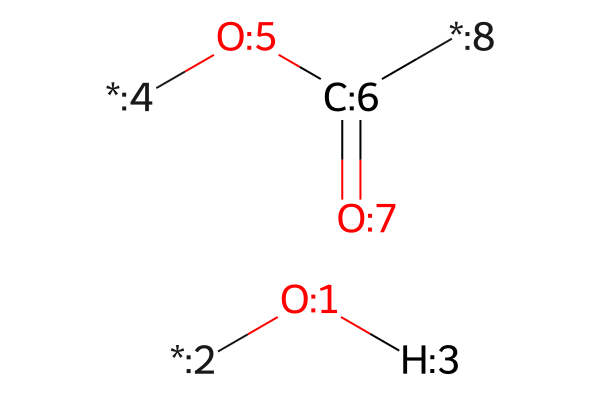

polyurethane_isocyanate {7: (5, 3), 2: (3, 5)}


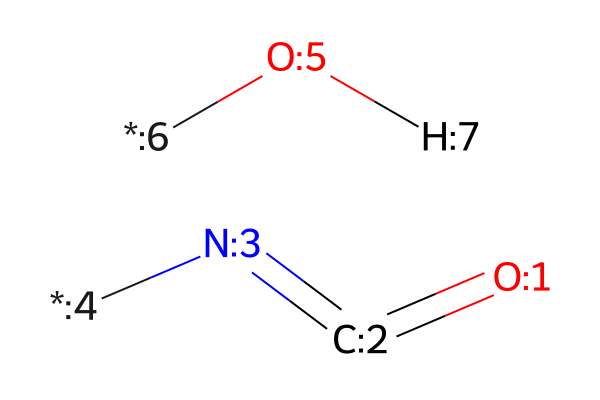

polyurethane_nonisocyanate {5: (4, 13), 11: (13, 4)}


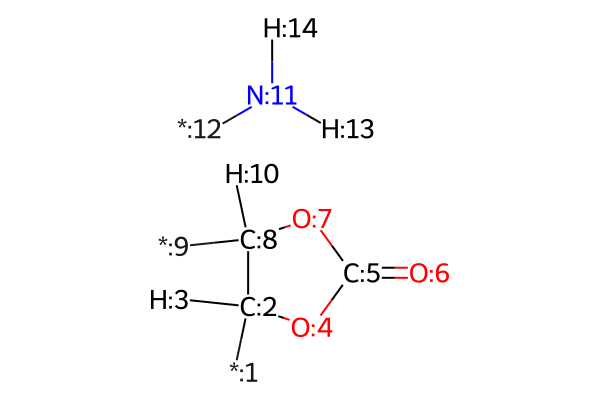

polyvinyl_head_tail {3: (2, 8), 12: (8, 2)}


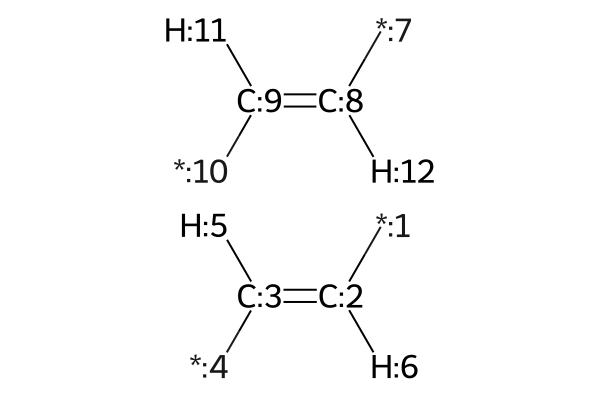

In [16]:
# display mechanism schemata prior to generating reactions (allows for inspection of derangement IDs)
for mech_name, mech_schema in mechanisms.items():
    print(mech_name, mech_schema.bond_derangement)
    display(mech_schema.reactants)

## Generating rxn MDL templates and SMARTS equations and saving to file

polyester
1 --x-> 3


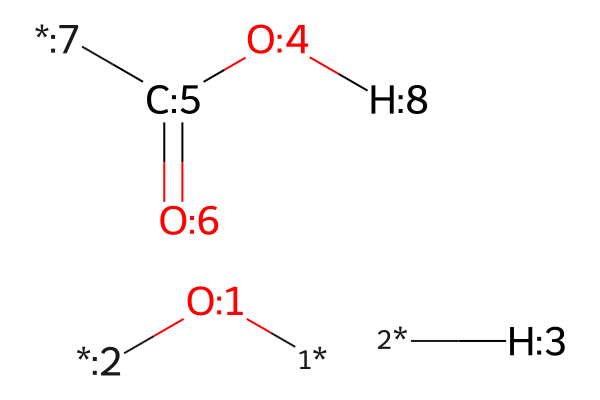

4 --x-> 5


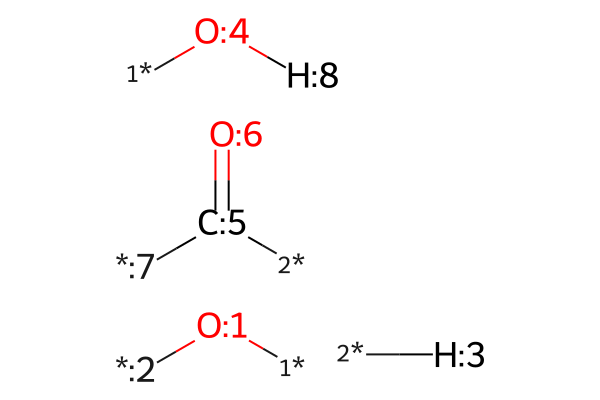

1 ----> 5


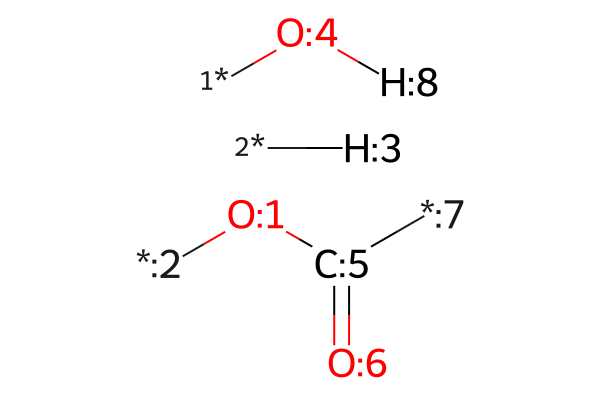

4 ----> 3


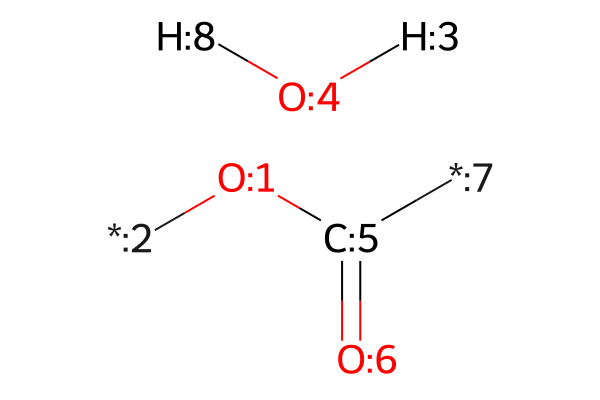

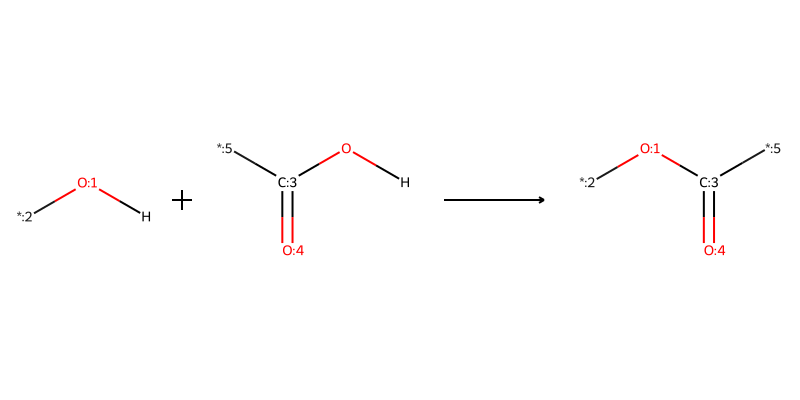

polyamide
1 --x-> 3


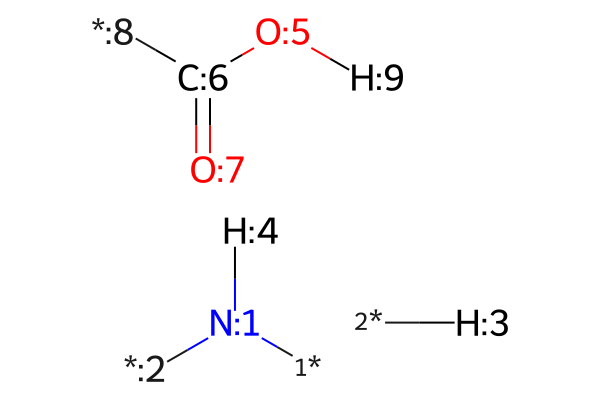

5 --x-> 6


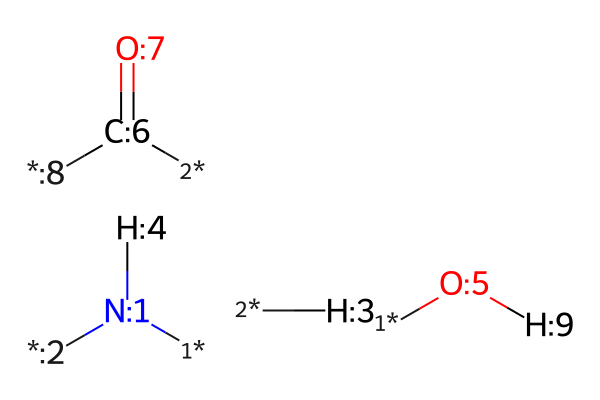

1 ----> 6


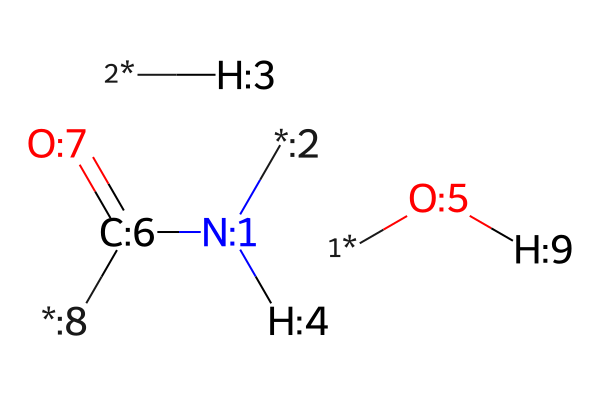

5 ----> 3


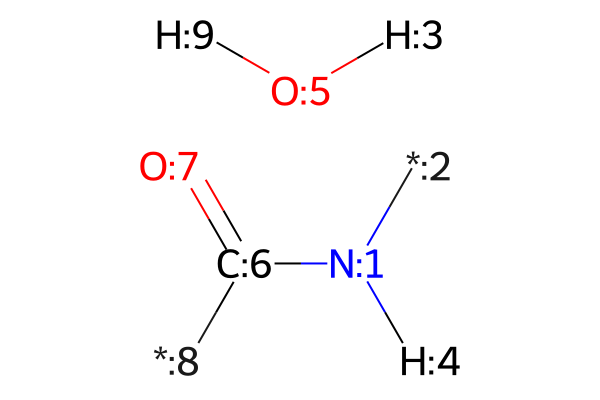

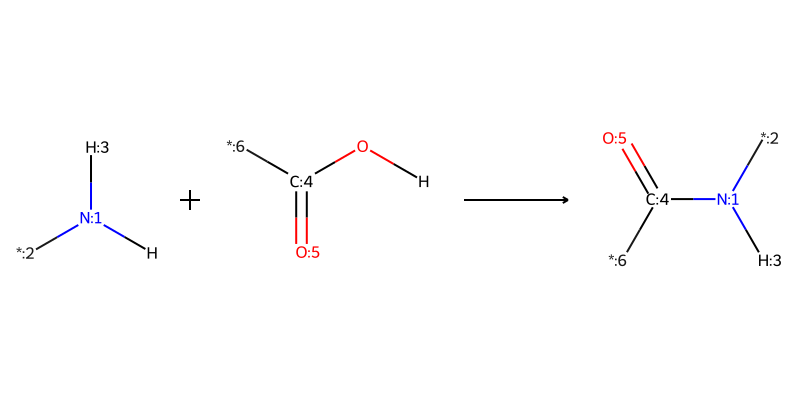

polyimide
4 --x-> 1


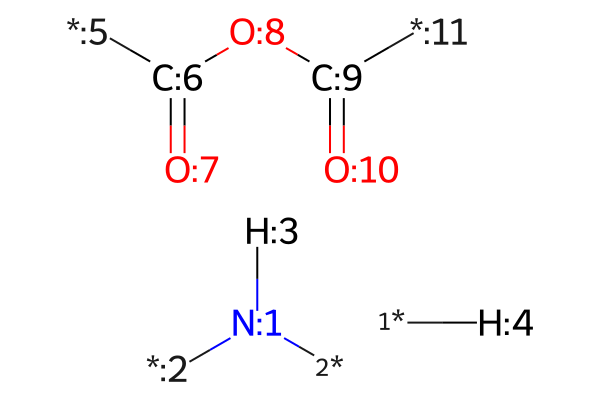

6 --x-> 8


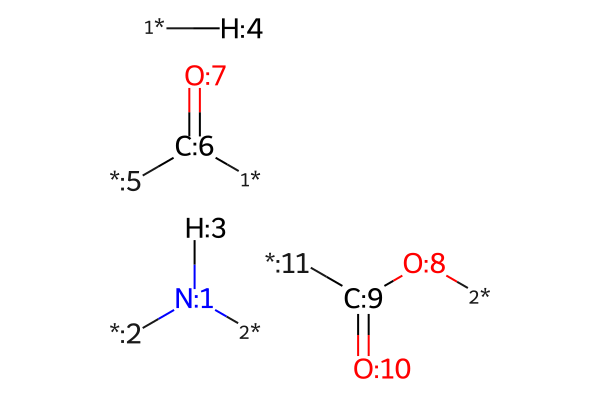

3 --x-> 1


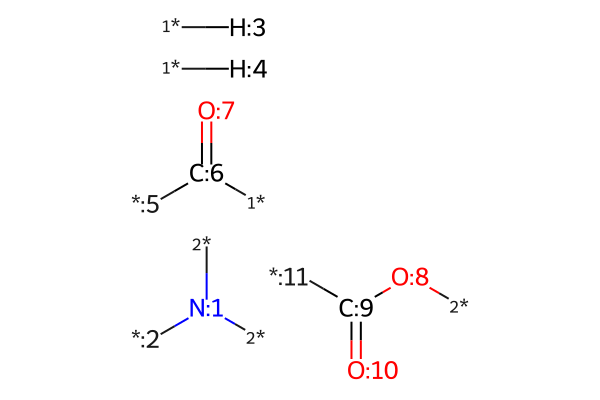

9 --x-> 8


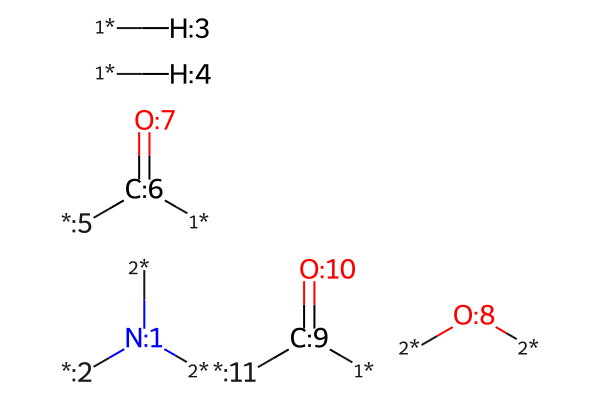

4 ----> 8


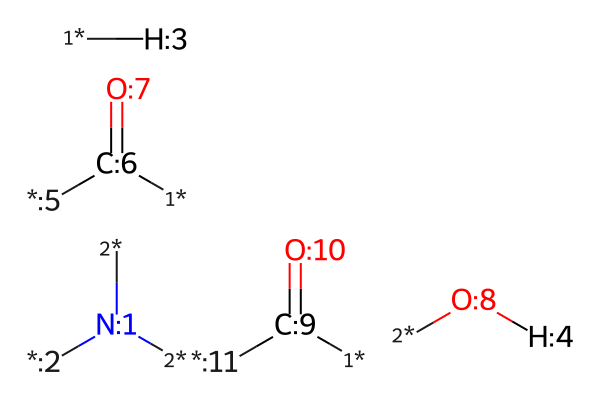

6 ----> 1


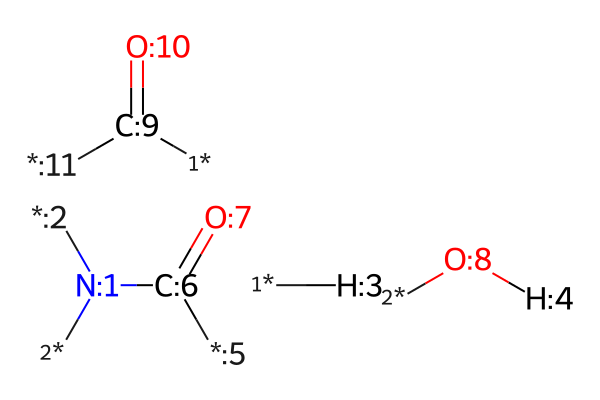

3 ----> 8


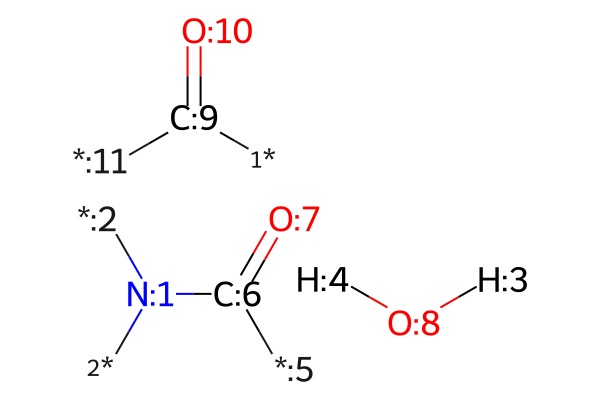

9 ----> 1


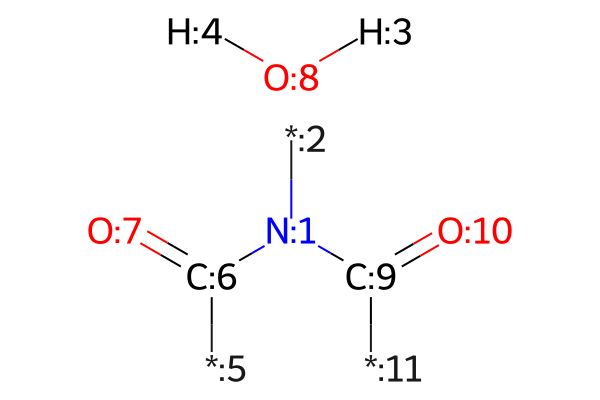

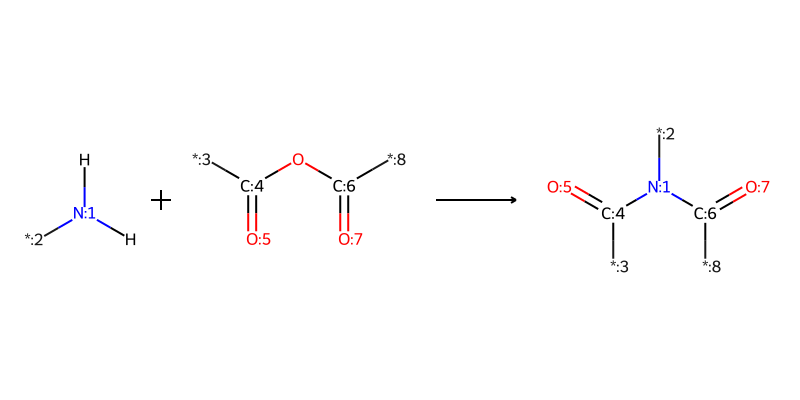

polycarbonate_phosgene
1 --x-> 3


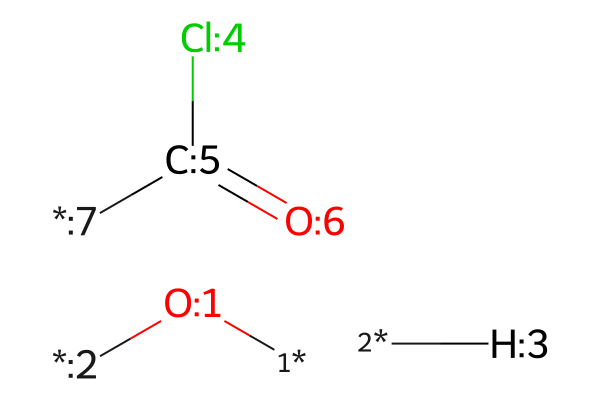

4 --x-> 5


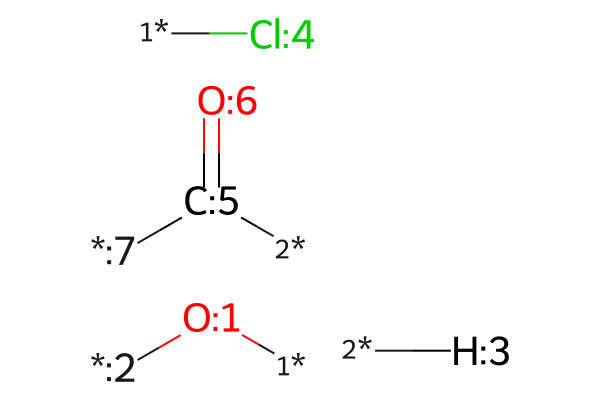

1 ----> 5


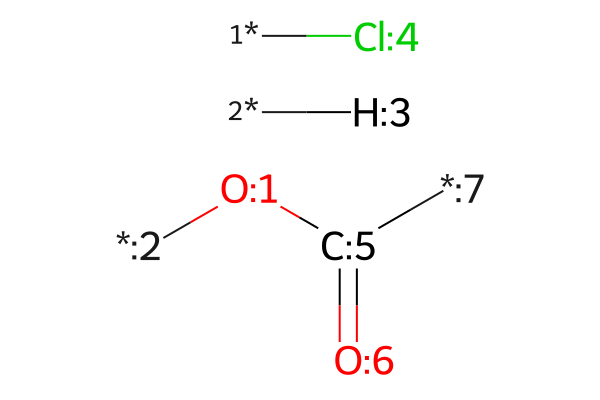

4 ----> 3


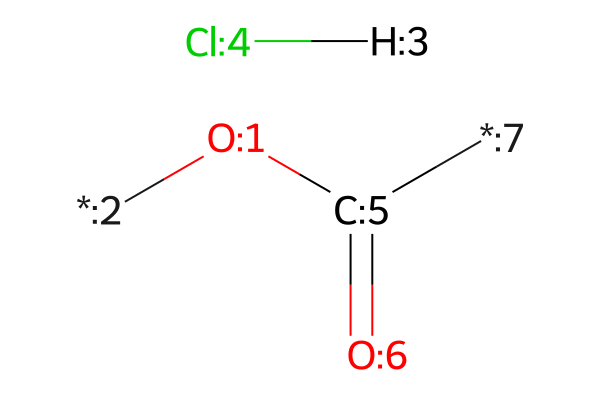

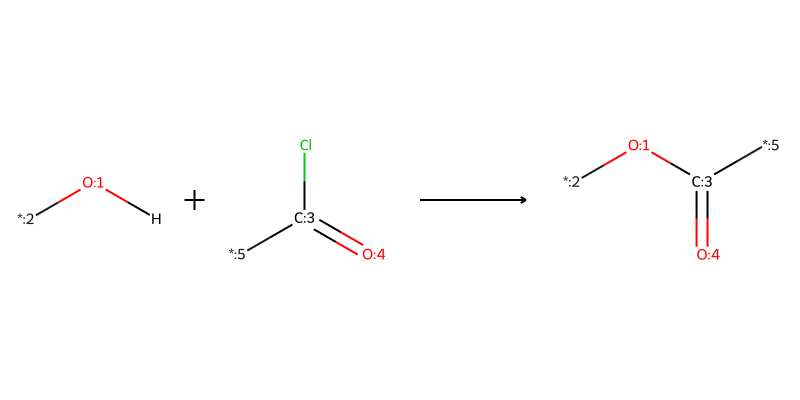

polycarbonate_nonphosgene
5 --x-> 6


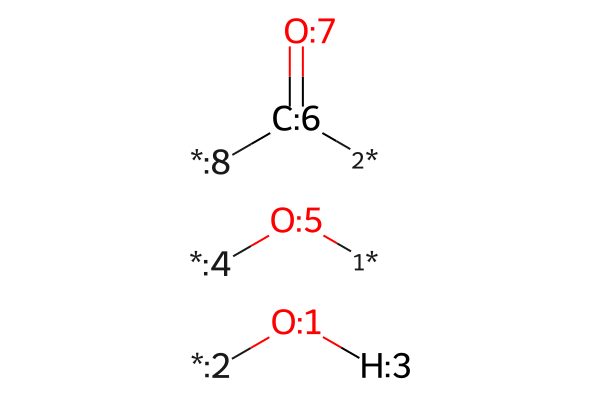

1 --x-> 3


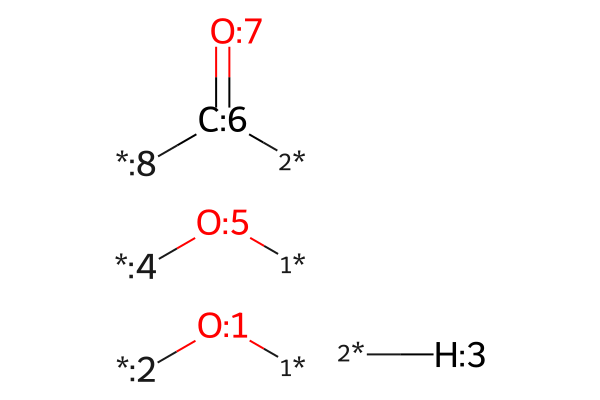

5 ----> 3


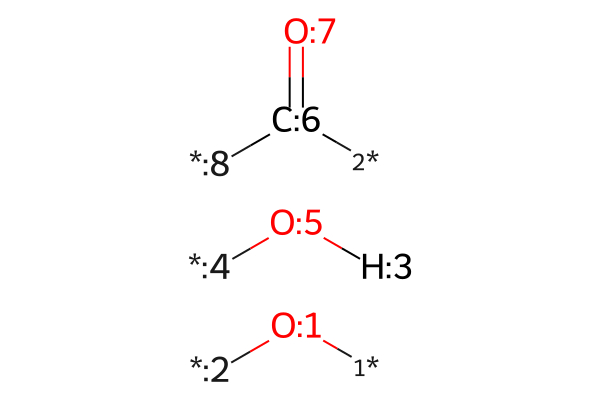

1 ----> 6


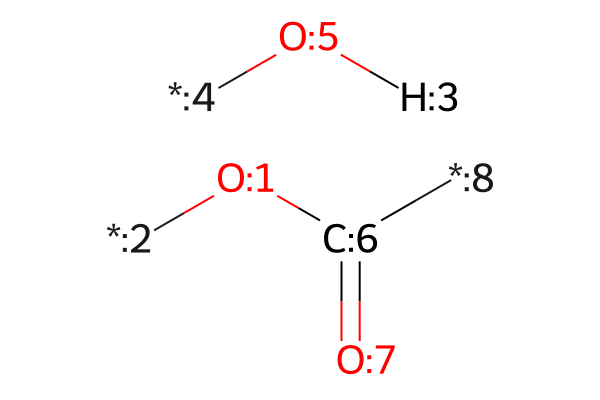

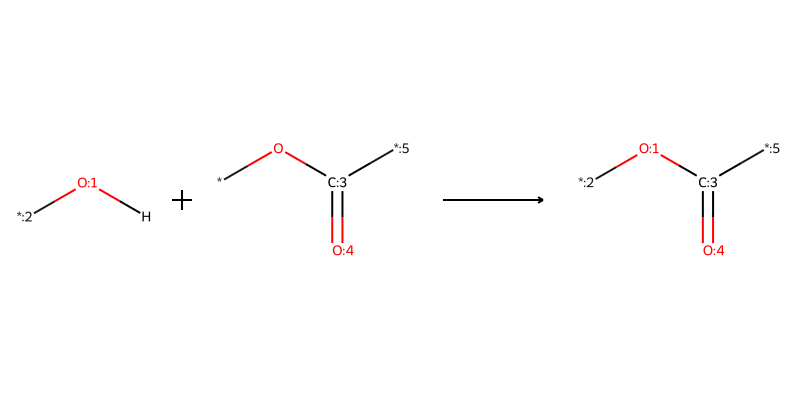

polyurethane_isocyanate
7 --x-> 5


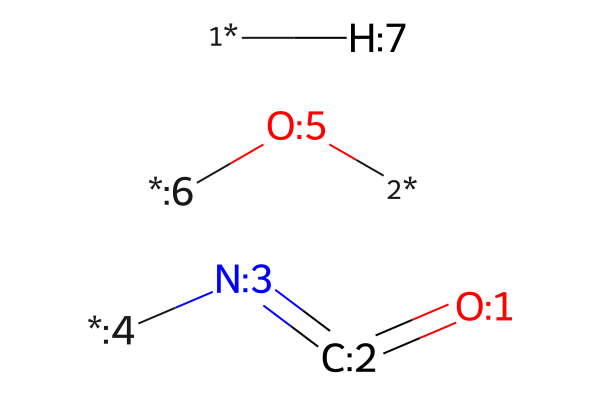

2 --x-> 3


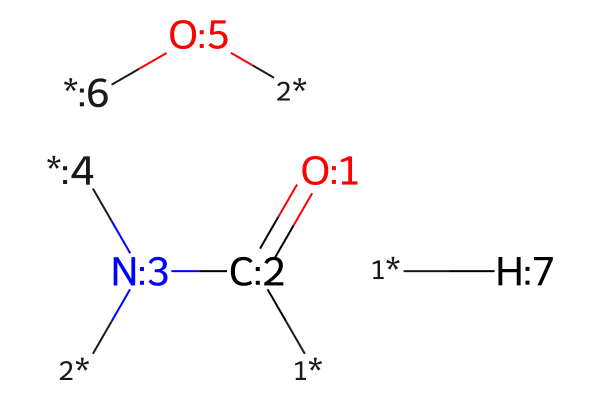

7 ----> 3


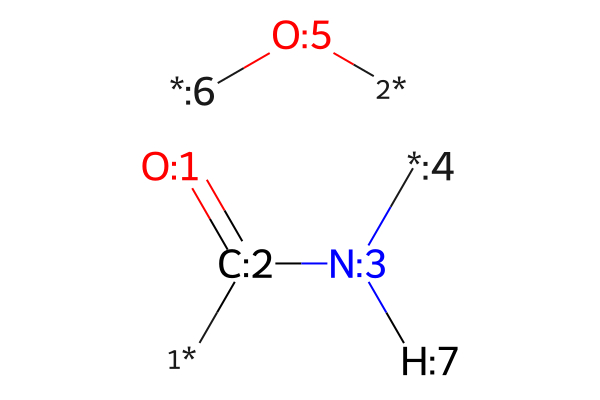

2 ----> 5


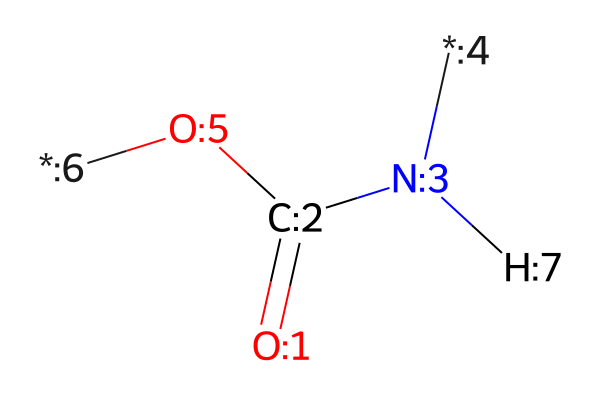

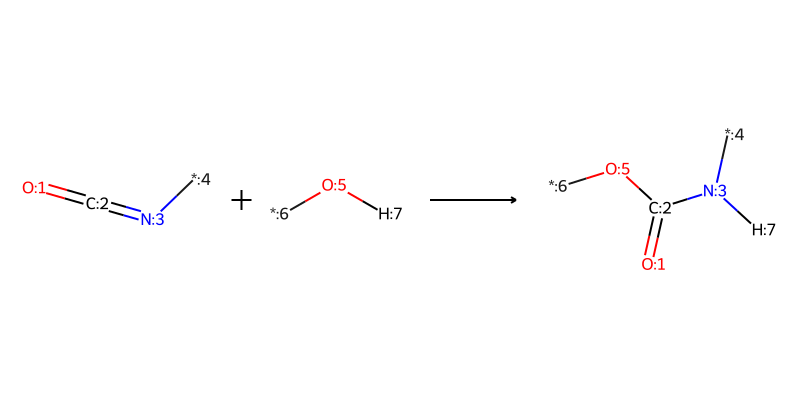

polyurethane_nonisocyanate
5 --x-> 4


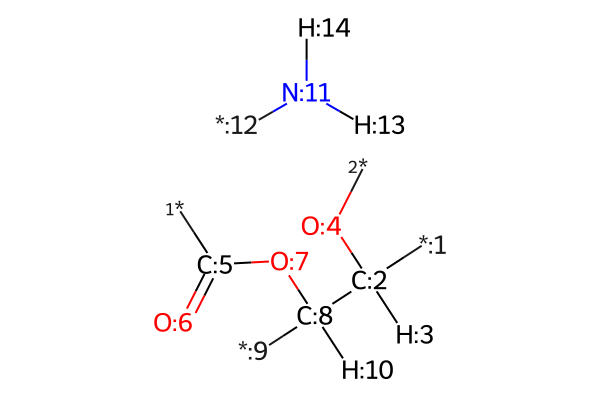

11 --x-> 13


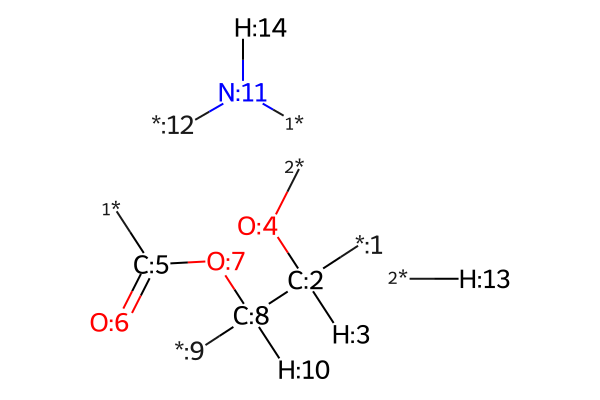

5 ----> 13


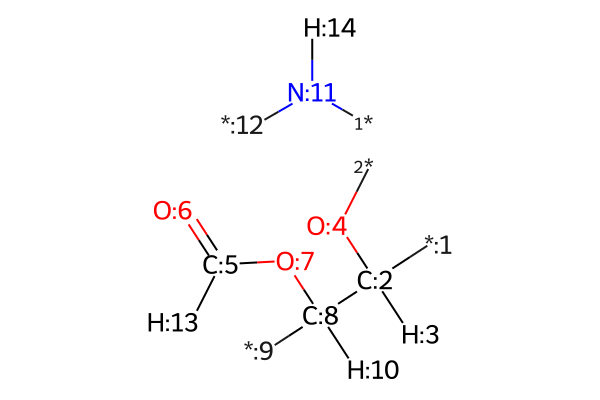

11 ----> 4


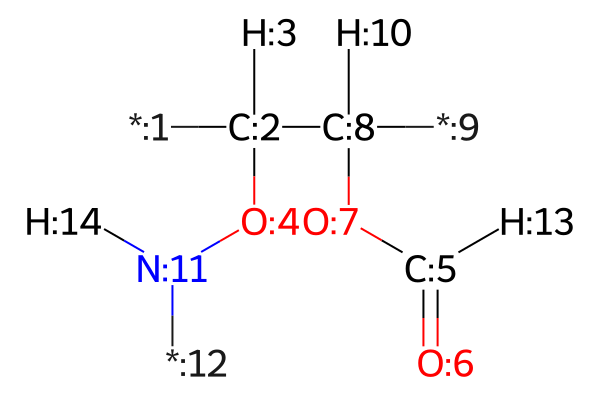

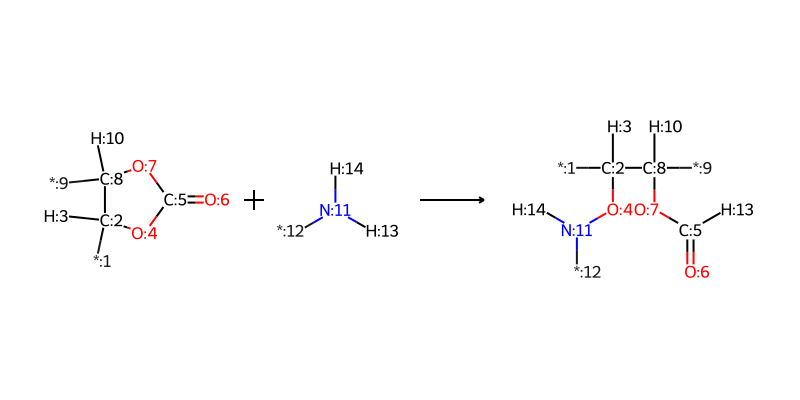

polyvinyl_head_tail
3 --x-> 2


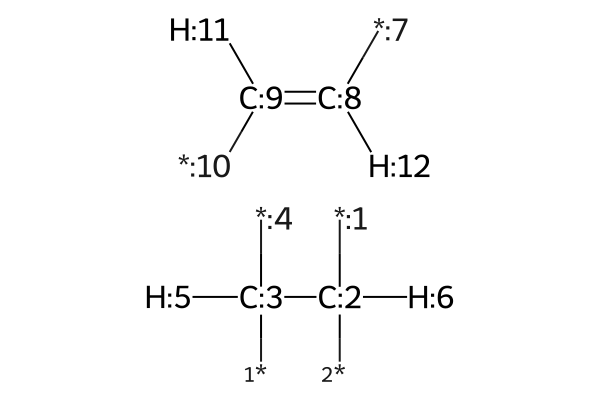

12 --x-> 8


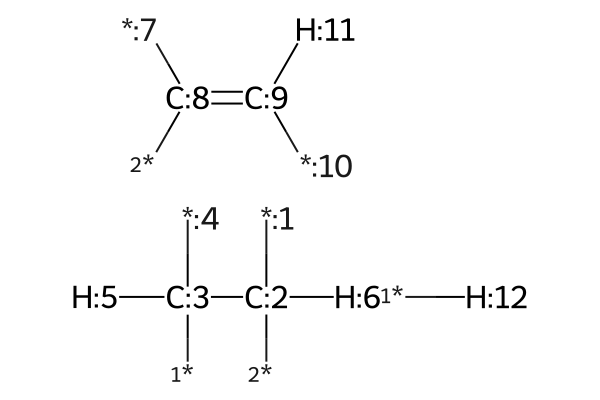

3 ----> 8


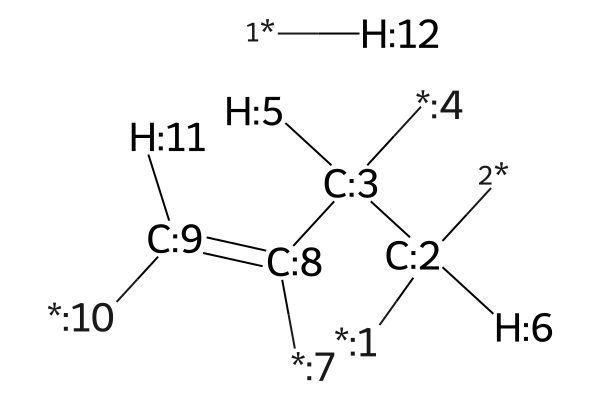

12 ----> 2


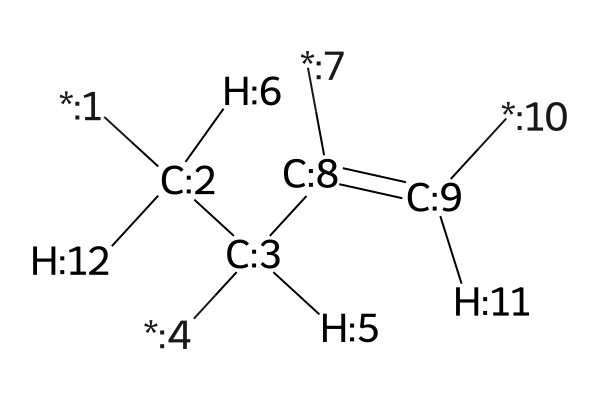

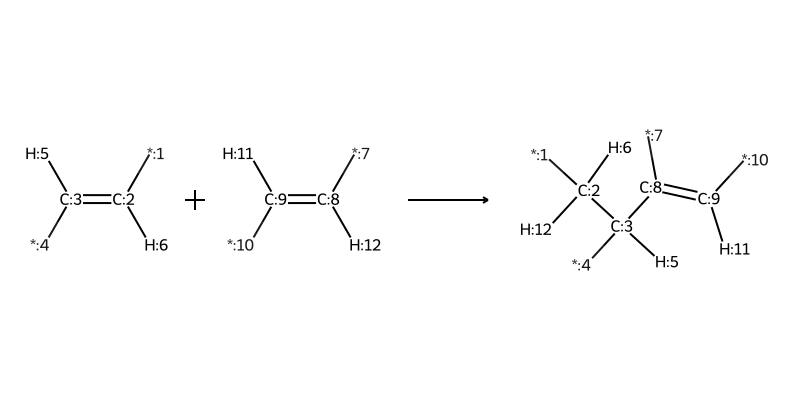

In [17]:
rxns, rxn_smarts = {}, {}
for mech_name, mech_schema in mechanisms.items():
    print(mech_name)
    rxn = mech_schema.assemble_rxn(show_steps=True)
    display(rxn)

    rxns[mech_name] = rxn
    rxn_smarts[mech_name] = rdChemReactions.ReactionToSmarts(rxn)

In [18]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn')

# Testing that reaction actually behave as intended

In [32]:
test_reactants = {
    'polyvinyl_head_tail' : ('C=C(CF)', 'C=C(CF)'),
    'polycarbonate_phosgene' : ('OCCO', 'ClC(=O)Cl'), 
    'polycarbonate_nonphosgene' : ('CC(C)(c1ccc(cc1)O)c2ccc(cc2)O', 'O=C(Oc1ccccc1)Oc2ccccc2'), 
}

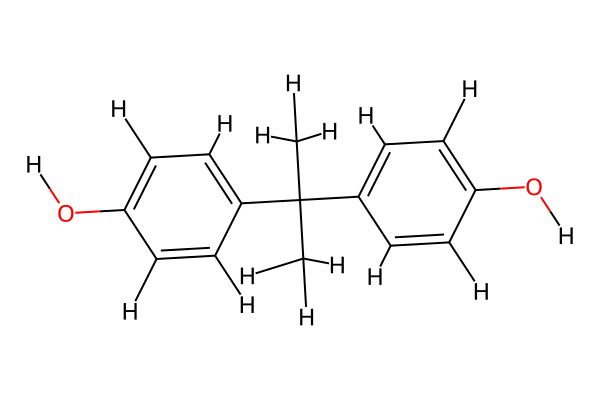

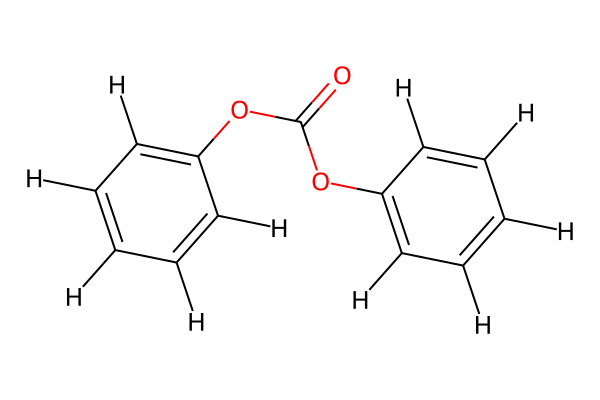

In [33]:
targ_rxn = 'polycarbonate_nonphosgene'

reactants = []        
for sm in test_reactants[targ_rxn]:
    exp_smiles = specification.expanded_SMILES(sm, assign_map_nums=False)
    reactant = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    display(reactant)
    reactants.append(reactant)

0 0


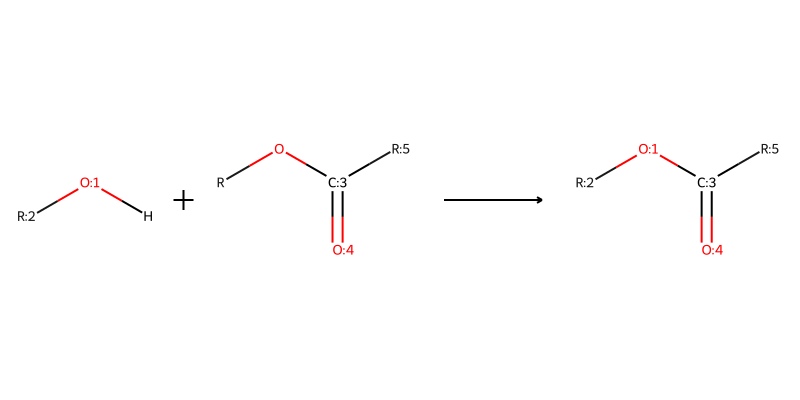

In [34]:
rxn = reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_PATH / f'{targ_rxn}.rxn')
rxn.Initialize()
num_warnings, num_errors = rxn.Validate()

print(num_warnings, num_errors)
display(rxn)

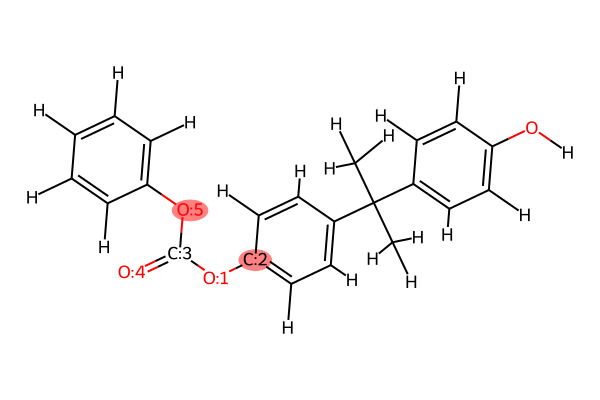

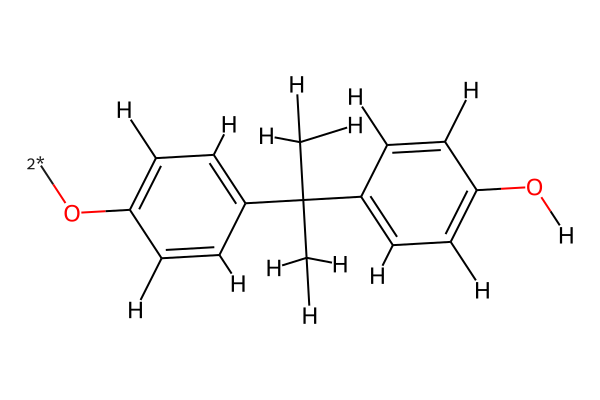

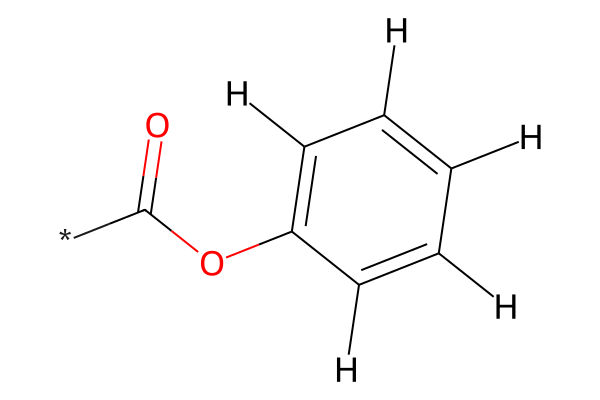

NoIntermonomerBondsFound: 

In [35]:
from polymerist.rdutils.reactions import reactors

reactor = reactors.PolymerizationReactor(rxn)
for dimer, frags in reactor.propagate(reactants):
    display(dimer)
    for frag in frags:
        display(frag)
    print('='*50)

# Playing with Stereo

In [ ]:
mech = mechanisms['polyvinyl_head_tail']

In [ ]:
product = mech.products_by_importance()[0]
product

In [ ]:
for atom in product.GetAtoms():
    print(atom.GetAtomMapNum(), atom.GetChiralTag())

In [ ]:
from polymerist.rdutils.labeling import molwise

stereo = Chem.FindPotentialStereo(product)
for ster_info in stereo:
    print(f'  Type: {ster_info.type}, Which: {ster_info.centeredOn}, Specified: {ster_info.specified}, Descriptor: {ster_info.descriptor} ')
    print(ster_info.centeredOn, next(molwise.map_nums_by_atom_ids(product, ster_info.centeredOn)))

In [ ]:
ster_info.type == Chem.StereoType.Bond_Double

In [ ]:
product

In [ ]:
from polymerist.rdutils.amalgamation import bonding, portlib

portlib.Port.bondable_flavors.insert((1, 2))
for atom_id in portlib.get_linker_ids(product):
    product.GetAtomWithIdx(atom_id).SetIsotope(1)

display(product)

bonding.saturate_ports(product, Chem.MolFromSmarts('[*:2]-[OH]'))
display(product)

In [ ]:
display(product)

Chem.FindPotentialStereoBonds(product)
for bond in product.GetBonds():
    if bond.GetStereo() == Chem.BondStereo.STEREOANY:
        print(bond.GetBeginAtom().GetAtomMapNum(), bond.GetEndAtom().GetAtomMapNum())
        bond.SetStereo(Chem.BondStereo.STEREOCIS)

display(product)

In [ ]:
Chem.MolToSmiles(product, isomericSmiles=True)

In [ ]:
bond.GetBeginAtom().GetAtomMapNum()

In [ ]:
cop = Chem.Mol(product)
for bond in cop.GetBonds():
    print(bond.GetStereo())

In [ ]:
type(bond.GetStereo())

In [ ]:
Chem.BondStereo.names

In [ ]:
Chem.StereoType.names

In [ ]:
dir(Chem.StereoInfo)

In [ ]:
Chem.ChiralType.names

In [ ]:
product.GetAtomWithIdx(2).SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
for atom in product.GetAtoms():
    print(atom.GetAtomMapNum(), atom.GetChiralTag())

display(product)

In [ ]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from rdkit.Chem.AllChem import EmbedMolecule

In [ ]:
options = StereoEnumerationOptions(
    onlyUnassigned=False
)

for isomer in EnumerateStereoisomers(product, options=options):
    display(isomer)
    print(Chem.MolToSmiles(isomer, isomericSmiles=True))

In [ ]:
Chem.BondDir.names

In [ ]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(isomer), sanitize=False)
display(m)

for bond in m.GetBonds():
    print(bond.GetPropsAsDict())

In [ ]:
for atom in mol.GetAtoms():
    if atom.HasProp('_ChiralityPossible'):
        print(atom.GetPropsAsDict(), atom.GetAtomMapNum())

In [ ]:
dir(sinfo)

In [ ]:
sinfo.descriptor

# Reverse-engineering example reactions from RDKit

In [ ]:
# rxn = rdChemReactions.ReactionFromRxnFile('test.rxn')
rxn = rdChemReactions.ReactionFromRxnFile('azide.rxn')
nWarn,nError,nReacts,nProds,reactantLabels = rdChemReactions.PreprocessReaction(rxn)
print(reactantLabels)
display(rxn)

In [ ]:
from polymerist.rdutils import rdprops

r1 = rxn.GetReactantTemplate(1)
print(Chem.MolToSmarts(r1))
display(r1)


rdprops.aggregate_atom_prop(r1, 'molFileValue', prop_type=str)